In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [2]:
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.model_selection import backtesting_forecaster
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from pandas.tseries import offsets
from skforecast import __version__
print(__version__)


0.11.0


In [3]:
# simulate a time series
n = 365
y = pd.Series(
    data=np.arange(n),
    index = pd.date_range(start='2000-01-01', periods=n, freq='d')
)
y

2000-01-01      0
2000-01-02      1
2000-01-03      2
2000-01-04      3
2000-01-05      4
             ... 
2000-12-26    360
2000-12-27    361
2000-12-28    362
2000-12-29    363
2000-12-30    364
Freq: D, Length: 365, dtype: int32

In [4]:
forecaster = ForecasterEquivalentDate(offset=10, n_offsets=2)
forecaster.fit(y=y)
forecaster

ForecasterEquivalentDate 
Offset: 10 
Number of offsets: 2 
Aggregation function: mean 
Window size: 20 
Training range: [Timestamp('2000-01-01 00:00:00'), Timestamp('2000-12-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Creation date: 2023-11-15 09:20:32 
Last fit date: 2023-11-15 09:20:32 
Skforecast version: 0.11.0 
Python version: 3.10.11 
Forecaster id: None 

In [5]:
forecaster.predict(steps=15)

2000-12-31    350.0
2001-01-01    351.0
2001-01-02    352.0
2001-01-03    353.0
2001-01-04    354.0
2001-01-05    355.0
2001-01-06    356.0
2001-01-07    357.0
2001-01-08    358.0
2001-01-09    359.0
2001-01-10    350.0
2001-01-11    351.0
2001-01-12    352.0
2001-01-13    353.0
2001-01-14    354.0
Freq: D, Name: pred, dtype: float64

In [6]:
metric, predictions_1 = backtesting_forecaster(
    forecaster=forecaster,
    y=y,
    initial_train_size=20,
    steps=15,
    metric='mean_absolute_error',
    verbose=False
)

  0%|          | 0/23 [00:00<?, ?it/s]

In [7]:
forecaster = ForecasterEquivalentDate(
    offset=offsets.Day(10),
    n_offsets=2
)
forecaster.fit(y=y)
forecaster

TypeError: object of type 'Timedelta' has no len()

In [ ]:
forecaster.predict(steps=15)

2000-12-31    350.0
2001-01-01    351.0
2001-01-02    352.0
2001-01-03    353.0
2001-01-04    354.0
2001-01-05    355.0
2001-01-06    356.0
2001-01-07    357.0
2001-01-08    358.0
2001-01-09    359.0
2001-01-10    350.0
2001-01-11    351.0
2001-01-12    352.0
2001-01-13    353.0
2001-01-14    354.0
Freq: D, Name: pred, dtype: float64

In [ ]:
from skforecast.ForecasterBaseline.tests.fixtures_ForecasterEquivalentDate import y

forecaster = ForecasterEquivalentDate(
    offset = offsets.Day(10),
    n_offsets=2
)

metric, predictions_2 = backtesting_forecaster(
    forecaster=forecaster,
    y=y,
    initial_train_size=30,
    steps=5,
    metric='mean_absolute_error',
    refit=True,
    verbose=False,
    n_jobs='auto'
)
predictions_2

  0%|          | 0/4 [00:00<?, ?it/s]

,pred
2000-01-31,0.488789
2000-02-01,0.789241
2000-02-02,0.581514
2000-02-03,0.335351
2000-02-04,0.560244
2000-02-05,0.530477
2000-02-06,0.272140
2000-02-07,0.201857
2000-02-08,0.412633
2000-02-09,0.581402


In [ ]:
metric

0.2537094475

In [ ]:
predictions_2.to_numpy().ravel()

array([0.48878949, 0.78924075, 0.58151378, 0.3353507 , 0.56024382,
       0.53047716, 0.27214019, 0.20185749, 0.41263271, 0.58140185,
       0.36325295, 0.64156648, 0.57765904, 0.5523543 , 0.57413684,
       0.31761006, 0.39406999, 0.56082619, 0.61893703, 0.5664064 ])

In [ ]:
pd.testing.assert_frame_equal(predictions_1, predictions_2)

In [ ]:
last_window_values = y.iloc[-20:].to_numpy()
last_window_values

array([345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357,
       358, 359, 360, 361, 362, 363, 364])

In [ ]:
offset = 7
n_offsets = 1
steps = 5

equivalent_indexes = np.tile(
                        np.arange(-offset, 0),
                        int(np.ceil(steps/offset))
                    )

equivalent_indexes

array([-7, -6, -5, -4, -3, -2, -1])

In [ ]:
# When n_offsets == 1
equivalent_indexes = equivalent_indexes[:steps]
print(equivalent_indexes)
equivalent_values = last_window_values[equivalent_indexes]
print(equivalent_values)
equivalent_values.ravel()

[-7 -6 -5 -4 -3]
[358 359 360 361 362]


array([358, 359, 360, 361, 362])

In [ ]:
offset = 7
n_offsets = 2
steps = 5

equivalent_indexes = np.tile(
                        np.arange(-offset, 0),
                        int(np.ceil(steps/offset))
                    )

equivalent_indexes

array([-7, -6, -5, -4, -3, -2, -1])

In [ ]:
# When n_offsets > 1
equivalent_indexes = [equivalent_indexes - n * offset 
                      for n in np.arange(n_offsets)]
print(equivalent_indexes)
equivalent_indexes = np.vstack(equivalent_indexes)
print(equivalent_indexes)
equivalent_values = last_window_values[equivalent_indexes]
print(equivalent_values)
predictions = np.apply_along_axis(
                np.mean,
                axis = 0,
                arr  = equivalent_values
            )
print(predictions)

[array([-7, -6, -5, -4, -3, -2, -1]), array([-14, -13, -12, -11, -10,  -9,  -8])]
[[ -7  -6  -5  -4  -3  -2  -1]
 [-14 -13 -12 -11 -10  -9  -8]]
[[358 359 360 361 362 363 364]
 [351 352 353 354 355 356 357]]
[354.5 355.5 356.5 357.5 358.5 359.5 360.5]


In [ ]:
last_window_values

array([345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357,
       358, 359, 360, 361, 362, 363, 364])

In [ ]:
y.index[-20:]

DatetimeIndex(['2000-12-11', '2000-12-12', '2000-12-13', '2000-12-14',
               '2000-12-15', '2000-12-16', '2000-12-17', '2000-12-18',
               '2000-12-19', '2000-12-20', '2000-12-21', '2000-12-22',
               '2000-12-23', '2000-12-24', '2000-12-25', '2000-12-26',
               '2000-12-27', '2000-12-28', '2000-12-29', '2000-12-30'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
offset = pd.offsets.Day(5)
n_offsets = 2
steps = 5

In [ ]:
last_window_values = y.to_numpy()
last_window_values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
from skforecast.utils import expand_index

predictions_index = expand_index(index=y.index, steps=steps)
print(predictions_index)
max_allowed_date = y.index[-1]
print(max_allowed_date)

DatetimeIndex(['2000-12-31', '2001-01-01', '2001-01-02', '2001-01-03',
               '2001-01-04'],
              dtype='datetime64[ns]', freq='D')
2000-12-30 00:00:00


In [ ]:
offset_dates = []
for date in predictions_index:
    selected_offsets = []
    while len(selected_offsets) < n_offsets:
        offset_date = date - offset
        if offset_date <= max_allowed_date:
            selected_offsets.append(offset_date)
        date = offset_date
    offset_dates.append(selected_offsets)

offset_dates = np.array(offset_dates)
print(offset_dates)

[[Timestamp('2000-12-26 00:00:00') Timestamp('2000-12-21 00:00:00')]
 [Timestamp('2000-12-27 00:00:00') Timestamp('2000-12-22 00:00:00')]
 [Timestamp('2000-12-28 00:00:00') Timestamp('2000-12-23 00:00:00')]
 [Timestamp('2000-12-29 00:00:00') Timestamp('2000-12-24 00:00:00')]
 [Timestamp('2000-12-30 00:00:00') Timestamp('2000-12-25 00:00:00')]]


In [ ]:
offset_dates.ravel()

array([Timestamp('2000-12-26 00:00:00'), Timestamp('2000-12-21 00:00:00'),
       Timestamp('2000-12-27 00:00:00'), Timestamp('2000-12-22 00:00:00'),
       Timestamp('2000-12-28 00:00:00'), Timestamp('2000-12-23 00:00:00'),
       Timestamp('2000-12-29 00:00:00'), Timestamp('2000-12-24 00:00:00'),
       Timestamp('2000-12-30 00:00:00'), Timestamp('2000-12-25 00:00:00')],
      dtype=object)

In [ ]:
equivalent_values = (
    y.
    reindex(offset_dates.ravel()))
equivalent_values

2000-12-26    360
2000-12-21    355
2000-12-27    361
2000-12-22    356
2000-12-28    362
2000-12-23    357
2000-12-29    363
2000-12-24    358
2000-12-30    364
2000-12-25    359
dtype: int32

In [ ]:
equivalent_values = (
    y.
    reindex(offset_dates.ravel())
    .to_numpy()
    .reshape(-1, n_offsets)
)
equivalent_values

array([[360, 355],
       [361, 356],
       [362, 357],
       [363, 358],
       [364, 359]])

In [ ]:
equivalent_values = pd.DataFrame(
                                    data    = equivalent_values,
                                    index   = predictions_index,
                                    columns = [f'offset_{i}' 
                                               for i in range(n_offsets)]
                                )
equivalent_values

,offset_0,offset_1
2000-12-31,360,355
2001-01-01,361,356
2001-01-02,362,357
2001-01-03,363,358
2001-01-04,364,359


In [ ]:
incomplete_offsets = equivalent_values.isnull().any(axis=1)
incomplete_offsets = incomplete_offsets[incomplete_offsets].index
incomplete_offsets

DatetimeIndex(['2000-12-31'], dtype='datetime64[ns]', freq='D')

In [ ]:
(f"Steps: {incomplete_offsets.strftime('%Y-%m-%d').to_list()} "
f"are calculated with less than {n_offsets} offsets. To avoid "
f"this increase `last_window` size or decrease the number "
f"of offsets. The current configuration needs a total offset "
f"of {offset * n_offsets}.")

"Steps: ['2000-12-31'] are calculated with less than 2 offsets. To avoid this increase `last_window` size or decrease the number of offsets. The current configuration needs a total offset of <12 * Days>."

In [ ]:
aggregate_values = equivalent_values.apply(np.mean, axis=1)
aggregate_values

2000-12-31    359.0
2001-01-01    357.0
2001-01-02    358.0
2001-01-03    359.0
2001-01-04    360.0
Freq: D, dtype: float64

In [ ]:
y = pd.Series(np.arange(30), index=pd.date_range(start='1999-12-31', periods=30, freq='D'))
y

1999-12-31     0
2000-01-01     1
2000-01-02     2
2000-01-03     3
2000-01-04     4
2000-01-05     5
2000-01-06     6
2000-01-07     7
2000-01-08     8
2000-01-09     9
2000-01-10    10
2000-01-11    11
2000-01-12    12
2000-01-13    13
2000-01-14    14
2000-01-15    15
2000-01-16    16
2000-01-17    17
2000-01-18    18
2000-01-19    19
2000-01-20    20
2000-01-21    21
2000-01-22    22
2000-01-23    23
2000-01-24    24
2000-01-25    25
2000-01-26    26
2000-01-27    27
2000-01-28    28
2000-01-29    29
Freq: D, dtype: int32

In [ ]:
forecaster = ForecasterEquivalentDate(
                     offset    = 30,
                     n_offsets = 1
                 )
forecaster.fit(y=y)
print(forecaster.window_size)
forecaster.predict(steps=3)

30


2000-01-30    0
2000-01-31    1
2000-02-01    2
Freq: D, Name: pred, dtype: int32

In [ ]:
lw = pd.Series(np.arange(3), 
               index=pd.date_range(start='2000-02-10', periods=3, freq='D'))
lw

2000-02-10    0
2000-02-11    1
2000-02-12    2
Freq: D, dtype: int32

In [ ]:
forecaster.predict(steps=3, last_window=lw)

ValueError: All equivalent values are missing. This is caused by using an offset (<MonthEnd>) larger than the data available. Try decrease the size of the offset (<MonthEnd>), the number of offsets (1) or increase the size of `last_window`. In backtesing this error may be caused by using an too small `initial_train_size`.

In [ ]:
y = pd.Series(np.arange(7), 
              index=pd.date_range(start='2000-02-25', periods=7, freq='D'))
y

2000-02-25    0
2000-02-26    1
2000-02-27    2
2000-02-28    3
2000-02-29    4
2000-03-01    5
2000-03-02    6
Freq: D, dtype: int32

In [ ]:
last_window_start = (y.index[-1] - pd.offsets.MonthEnd(1) * 1)
last_window_start

Timestamp('2000-02-29 00:00:00')

In [ ]:
print(y.index[-1])
print(last_window_start)
print(y.index.freq)

2000-03-02 00:00:00
2000-02-29 00:00:00
<Day>


In [ ]:
window_size = int((y.index[-1] - last_window_start) / y.index.freq)
window_size

2

In [ ]:
y = pd.Series(np.arange(51), 
              index=pd.date_range(start='2000-01-25', periods=51, freq='D'))

forecaster = ForecasterEquivalentDate(
                    offset    = pd.offsets.MonthEnd(1),
                    n_offsets = 2
                )
forecaster.fit(y=y)
print(forecaster.window_size)

last_window = pd.Series(np.arange(50), 
                        index=pd.date_range(start='2000-02-10', periods=50, freq='D'))

forecaster.predict(steps=3, last_window=last_window)

44


c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterBaseline\ForecasterEquivalentDate.py:402: UserWarning: Steps: ['2000-03-31', '2000-04-01', '2000-04-02'] are calculated with less than 2 n_offsets. To avoid this, increase the `last_window` size or decrease the number of n_offsets. The current configuration requires a total offset of <2 * MonthEnds>.
  warnings.warn(


2000-03-31    19.0
2000-04-01    19.0
2000-04-02    19.0
Freq: D, Name: pred, dtype: float64

In [9]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_squared_error

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
Freq: MS, Name: litters, dtype: float64

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1985-01-01 00:00:00  (n=60)


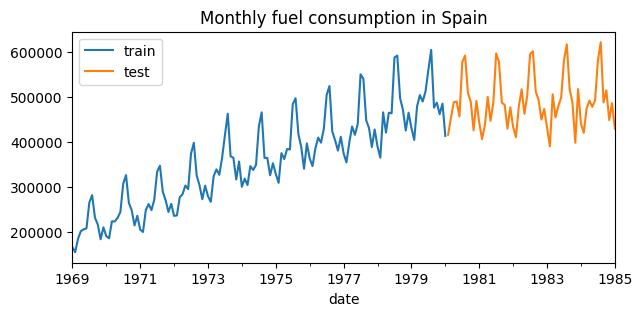

In [10]:
# Download data
# ======================================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/consumos-combustibles-mensual.csv'
)
data = pd.read_csv(url, sep=',')
data = data[['Fecha', 'Gasolinas']]
data = data.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.loc[:'1985-01-01 00:00:00']
data = data.asfreq('MS')
data = data['litters']
display(data.head(4))

# Train-test dates
# ======================================================================================
end_train = '1980-01-01 23:59:59'
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

In [11]:
data_daily = data_train.copy()
data_daily.index = pd.date_range(start=data_daily.index[0], periods=len(data_daily), freq='D')
data_daily

1969-01-01    166875.2129
1969-01-02    155466.8105
1969-01-03    184983.6699
1969-01-04    202319.8164
1969-01-05    206259.1523
                 ...     
1969-05-09    476677.5163
1969-05-10    487880.0221
1969-05-11    462139.3874
1969-05-12    485646.8776
1969-05-13    413886.2617
Freq: D, Name: litters, Length: 133, dtype: float64

In [ ]:
forecaster = ForecasterEquivalentDate(
                 offset    = pd.offsets.MonthEnd(1),
                 n_offsets = 2,
                 agg_func  = np.mean
             )

In [12]:
y_index = data_train.index
y_index = data_daily.index
y_index

DatetimeIndex(['1969-01-01', '1969-01-02', '1969-01-03', '1969-01-04',
               '1969-01-05', '1969-01-06', '1969-01-07', '1969-01-08',
               '1969-01-09', '1969-01-10',
               ...
               '1969-05-04', '1969-05-05', '1969-05-06', '1969-05-07',
               '1969-05-08', '1969-05-09', '1969-05-10', '1969-05-11',
               '1969-05-12', '1969-05-13'],
              dtype='datetime64[ns]', length=133, freq='D')

In [13]:
first_valid_index = (y_index[-1] - forecaster.offset * forecaster.n_offsets)
first_valid_index

Timestamp('1969-04-23 00:00:00')

In [18]:
y_index[-1] - first_valid_index

Timedelta('20 days 00:00:00')

In [15]:
y_index.freq

<Day>

In [16]:
(y_index[-1] - first_valid_index) / y_index.freq

20.0

In [19]:
abs(y_index[-1] - first_valid_index)

Timedelta('20 days 00:00:00')

In [20]:
index_point1 = y_index.get_loc(y_index[-1])
index_point2 = y_index.get_loc(first_valid_index)

abs(index_point1 - index_point2)

20

In [21]:
y_index

DatetimeIndex(['1969-01-01', '1969-01-02', '1969-01-03', '1969-01-04',
               '1969-01-05', '1969-01-06', '1969-01-07', '1969-01-08',
               '1969-01-09', '1969-01-10',
               ...
               '1969-05-04', '1969-05-05', '1969-05-06', '1969-05-07',
               '1969-05-08', '1969-05-09', '1969-05-10', '1969-05-11',
               '1969-05-12', '1969-05-13'],
              dtype='datetime64[ns]', length=133, freq='D')

In [30]:
other_no_valid_index = pd.to_datetime('1969-04-23')
other_no_valid_index

Timestamp('1969-04-23 00:00:00')

In [34]:
%%timeit -n 1000 -r 4

y_index.to_list().index(other_no_valid_index)

96.8 µs ± 10.1 µs per loop (mean ± std. dev. of 4 runs, 1,000 loops each)


In [33]:
%%timeit -n 1000 -r 4

y_index.get_loc(other_no_valid_index)

3.79 µs ± 381 ns per loop (mean ± std. dev. of 4 runs, 1,000 loops each)


In [7]:
y = pd.Series(np.arange(10))

forecaster = ForecasterEquivalentDate(
        offset=6, n_offsets=2, agg_func=np.mean
    )

forecaster.fit(y)

ValueError: The length of `y` (10), must be greater than or equal to the window size (12). This is because  the offset (6) is larger than the available data. Try to decrease the size of the offset (6), the number of n_offsets (2) or increase the size of `y`.

In [8]:
y = pd.Series(np.arange(10), 
              index=pd.date_range(start='01/01/2021', periods=10, freq='MS'))

forecaster = ForecasterEquivalentDate(
                     offset        = DateOffset(months=6),
                     n_offsets     = 2,
                     agg_func      = np.mean,
                     forecaster_id = None
                 )

forecaster.fit(y)

ValueError: The length of `y` (10), must be greater than or equal to the window size (<2 * DateOffsets: months=6>). This is because  the offset (<DateOffset: months=6>) is larger than the available data. Try to decrease the size of the offset (1), the number of n_offsets (2) or increase the size of `y`.

In [20]:
a = DateOffset(days=6)
print(a)

<DateOffset: days=6>


In [13]:
b = pd.offsets.MonthEnd(2)
print(b)
b.n

<2 * MonthEnds>


2

In [21]:
last_window = pd.Series(
        data = np.array([0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                         0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]),
        index = pd.date_range(start='2000-08-05', periods=10, freq='MS'),
        name = 'y'
    )
last_window

2000-09-01    0.737995
2000-10-01    0.182492
2000-11-01    0.175452
2000-12-01    0.531551
2001-01-01    0.531828
2001-02-01    0.250455
2001-03-01    0.483034
2001-04-01    0.985560
2001-05-01    0.519485
2001-06-01    0.612895
Freq: MS, Name: y, dtype: float64